In [ ]:
!head /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0


In [ ]:
#import packages

!pip install --upgrade statsmodels

import numpy as np
import itertools as it
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import seaborn as sns
import time
import pickle
# import multiprocessing
import warnings
#import parmap

from tqdm import tqdm
from PIL import Image
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import statsmodels.tools.eval_measures as eval
from datetime import datetime
from sklearn.preprocessing import StandardScaler

import sklearn.metrics as metrics

tot_run_time_start = time.time()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
#%% Plot style
plt.style.use('default')

mpl.rcParams['axes.unicode_minus'] = False

# Matplotlib fontsize change
SMALL_SIZE = 15
MEDIUM_SIZE = 20
LARGE_SIZE = 25

plt.rc('font', size=SMALL_SIZE, weight='bold')
plt.rc('axes', titlesize=LARGE_SIZE, titleweight='bold')
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')
plt.rc('axes', titleweight='bold')
plt.rc('xtick', labelsize=LARGE_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=LARGE_SIZE)

# Save figure settings
high_dpi = 300
fig_file_ext = '.png'
Image.MAX_IMAGE_PIXELS=None # Ignore DecompressionBombError

In [ ]:
daily_multi_train = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi_train.csv')
daily_multi_test = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_multi_test.csv')
daily_single_train = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/BTC_updated.csv')
daily_single_test = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/daily_single_test.csv')

hourly_multi_train = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/hourly_multi_train.csv')
hourly_multi_test = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/hourly_multi_test.csv')
hourly_single_train = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/hourly_single_train.csv')
hourly_single_test = pd.read_csv('https://raw.githubusercontent.com/mlee687/CS470_AI-auto-trading/main/hourly_single_test.csv')

In [ ]:
#import preprocessed data
#month/day/year - use close in single.



def change_str_to_timestamp(x):
  for i, value in enumerate(x['Timestamp']):
      # print(i)
      value = value[:-6]
      part1 = value[:-2]
      part2 = value[-2:]
      value = part1 + "20" +part2
      value = time.mktime(datetime.strptime(value, "%m/%d/%Y").timetuple())
      x['Timestamp'][i] = int(value)
  return x

def change_timestamp_to_str(x):
  for i, value in enumerate(x['Timestamp']):
    x['Timestamp'][i] = pd.to_datetime(value, unit='s')
  return x

def sort_data(x):
  x = change_str_to_timestamp(x)
  x = x.sort_values(by='Timestamp')
  x = x.reset_index()
  
  x = x.drop(['index'], axis =1)
  x= change_timestamp_to_str(x)
  # print(x.head())
  return x

# daily_single_train = sort_data(daily_single_train)
scaler1 = StandardScaler()
daily_single_test = daily_single_train[int(daily_single_train.shape[0]*0.8):]
daily_single_train = daily_single_train[:int(daily_single_train.shape[0]*0.8)]
scaler1.fit(daily_single_train['Close'].to_numpy().reshape(-1,1))
daily_single_train['Close'] = scaler1.transform(daily_single_train['Close'].to_numpy().reshape(-1,1))
daily_single_test['Close'] = scaler1.transform(daily_single_test['Close'].to_numpy().reshape(-1,1))
daily_single_train = daily_single_train.drop(columns=['Open', 'High', 'Low', 'Volume'])
daily_single_test = daily_single_test.drop(columns=['Open', 'High', 'Low', 'Volume'])
# daily_single_train_log = daily_single_train.apply(lambda x:np.log(x) if x.name in ['Daily_Close'] else x)
# daily_single_test_log = daily_single_test.apply(lambda x:np.log(x) if x.name in ['Daily_Close'] else x)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# daily_single_train = pd.DataFrame(daily_single_train)
# daily_single_test = pd.DataFrame(daily_single_test)
daily_single_train.shape
daily_single_test.shape
# daily_single_test.head()

(564, 2)

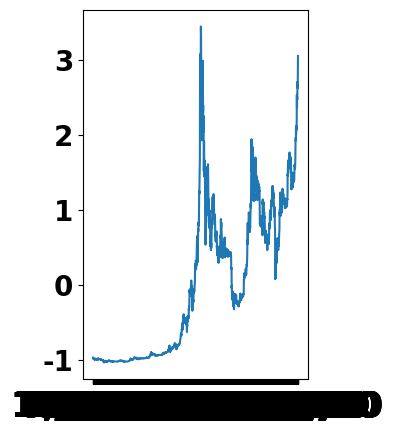

In [ ]:
plt.subplot(1,2,1)
plt.plot(daily_single_train['Date'], daily_single_train['Close'])
# plt.subplot(1,2,2)
# plt.plot(daily_single_train['Timestamp'],daily_single_train_log['Daily_Close'] )
plt.show()




Date      object
Close    float64
dtype: object


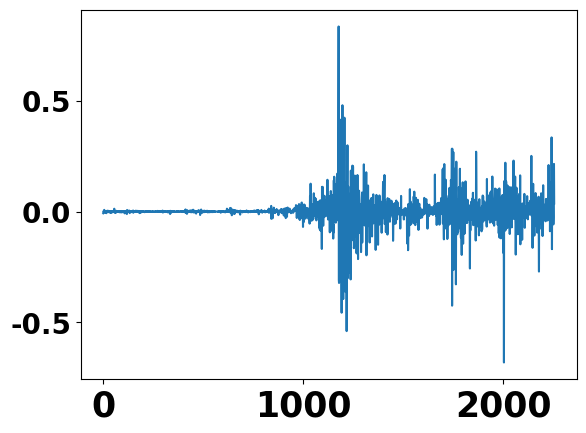

In [ ]:
# daily_single_train_diff1 = daily_single_train.diff(1).dropna()
# daily_single_train_diff2 = daily_single_train.diff(2).dropna()
# daily_single_test_diff1 = daily_single_test.diff(1).dropna()
# daily_single_test_diff2 = daily_single_test.diff(2).dropna()
# daily_single_train_diff1['Daily_Close'].plot()
# daily_single_train_diff2['Daily_Close'].plot()
daily_single_train['Close'] = daily_single_train['Close'].astype(float)
daily_single_test['Close'] = daily_single_test['Close'].astype(float)

print (daily_single_train.dtypes)
daily_single_train_diff1 = daily_single_train['Close'].diff(1).dropna()
daily_single_train_diff2 = daily_single_train['Close'].diff(2).dropna()
daily_single_train_diff1.plot()



In [ ]:
#Augmented Dickey-Fuller test
def adf_test(x):
  print('Results of ADF test')
  dftest = adfuller(x, autolag = 'AIC')
  dfoutput = pd.Series(dftest[0:4], index =['test statistic', 'p-value', '# of lags', '# of observations'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value ({})'.format(key)] =value
  print(dfoutput)

adf_test(daily_single_train['Close'])
# adf_test(daily_single_train['Daily_Close'])
adf_test(daily_single_train_diff1)
adf_test(daily_single_train_diff2)


Results of ADF test
test statistic            -0.568333
p-value                    0.877978
# of lags                 27.000000
# of observations       2227.000000
Critical Value (1%)       -3.433290
Critical Value (5%)       -2.862839
Critical Value (10%)      -2.567461
dtype: float64
Results of ADF test
test statistic         -8.483374e+00
p-value                 1.373919e-13
# of lags               2.600000e+01
# of observations       2.227000e+03
Critical Value (1%)    -3.433290e+00
Critical Value (5%)    -2.862839e+00
Critical Value (10%)   -2.567461e+00
dtype: float64
Results of ADF test
test statistic         -8.311563e+00
p-value                 3.776752e-13
# of lags               2.700000e+01
# of observations       2.225000e+03
Critical Value (1%)    -3.433292e+00
Critical Value (5%)    -2.862840e+00
Critical Value (10%)   -2.567462e+00
dtype: float64


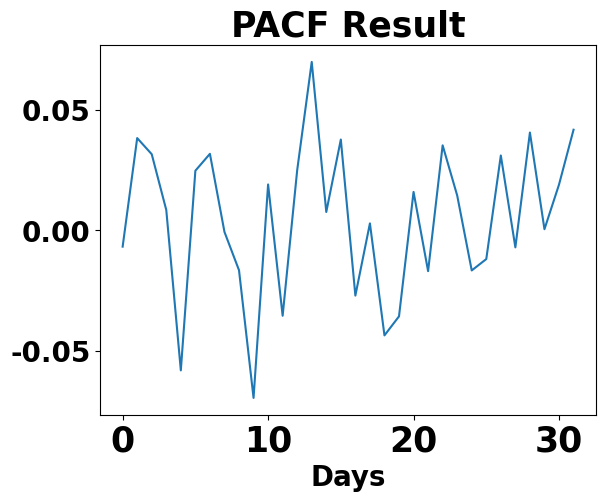

In [ ]:
pacf1 = pacf(daily_single_train['Close'])
pd.DataFrame(pacf1[2:]).plot(title = "PACF Result", legend =False, label='pacf', xlabel = "Days")


In [ ]:
# use different parameter on ARIMA

p = [i for i in range(0,20)]
q = [i for i in range(0, 20)]
print(p)
d = range(1, 3)
params_arima = list(it.product(p, d, q))
print(params_arima)

combs_aic = {}
aics = []

# train_Y = daily_single_train.loc[daily_single_train.shape[0]*9//10:]
# train_X = daily_single_train.loc[:daily_single_train.shape[0]*9//10]
# daily_single_test.head()




for i, param in enumerate(tqdm(params_arima)):
    # try:
        mdl = ARIMA(daily_single_train['Close'], 
                    order=param, 
                    enforce_invertibility=False,
                    enforce_stationarity=False
                    )
        mdl_fit = mdl.fit()
        combs_aic.update({mdl_fit.aic : param})
        aics.append(mdl_fit.aic)

    # except: continue

mdl_arima_best_aic = min(aics)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[(0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 1, 6), (0, 1, 7), (0, 1, 8), (0, 1, 9), (0, 1, 10), (0, 1, 11), (0, 1, 12), (0, 1, 13), (0, 1, 14), (0, 1, 15), (0, 1, 16), (0, 1, 17), (0, 1, 18), (0, 1, 19), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 2, 6), (0, 2, 7), (0, 2, 8), (0, 2, 9), (0, 2, 10), (0, 2, 11), (0, 2, 12), (0, 2, 13), (0, 2, 14), (0, 2, 15), (0, 2, 16), (0, 2, 17), (0, 2, 18), (0, 2, 19), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 1, 6), (1, 1, 7), (1, 1, 8), (1, 1, 9), (1, 1, 10), (1, 1, 11), (1, 1, 12), (1, 1, 13), (1, 1, 14), (1, 1, 15), (1, 1, 16), (1, 1, 17), (1, 1, 18), (1, 1, 19), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 2, 6), (1, 2, 7), (1, 2, 8), (1, 2, 9), (1, 2, 10), (1, 2, 11), (1, 2, 12), (1, 2, 13), (1, 2, 14), (1, 2, 15), (1, 2, 16), (1, 2, 17), (1, 2, 18), (1, 2, 19), (2, 1, 0

  3%|▎         | 24/800 [00:52<28:20,  2.19s/it]


KeyboardInterrupt: ignored

In [ ]:

p = [9]
q = [5]
print(p)
d = range(1,2)
params_arima = list(it.product(p, d, q))
print(params_arima)

mdl = ARIMA(daily_single_train['Close'], 
                    order=param, 
                    enforce_invertibility=False,
                    enforce_stationarity=False
                    )
mdl_fit = mdl.fit()

[9]
[(9, 1, 5)]


In [ ]:
print(mdl_fit.aic)
# 100, 1, 100

In [ ]:
daily_single_test['Close'].index.start
daily_single_test.shape[0]

In [ ]:
history = [x for x in daily_single_train['Close']]
print(len(history))

In [ ]:
history = [x for x in daily_single_train['Close']]
model_predictions = []
params_arima = (9,1,5)


for time_point in range(100):
  model = ARIMA(history, order = params_arima)
  model_fit = model.fit()
  output = model_fit.forecast()[0]
  model_predictions.append(output)
  true_val = daily_single_test['Close'][daily_single_test['Close'].index.start + time_point + 464]
  history.append(true_val)


# mdl_stat_arima_aic = ARIMA(daily_single_train['Daily_Close'],
#                            order=combs_aic[mdl_arima_best_aic],
#                            enforce_invertibility=False,
#                     enforce_stationarity=False
#                     )
# mdl_stat_arima_aic_fit = mdl_stat_arima_aic.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

In [ ]:
daily_single_test['Date'][:100]

['2/26/22', '3/18/22', '4/7/22', '4/27/22', '5/17/22', '6/5/22']


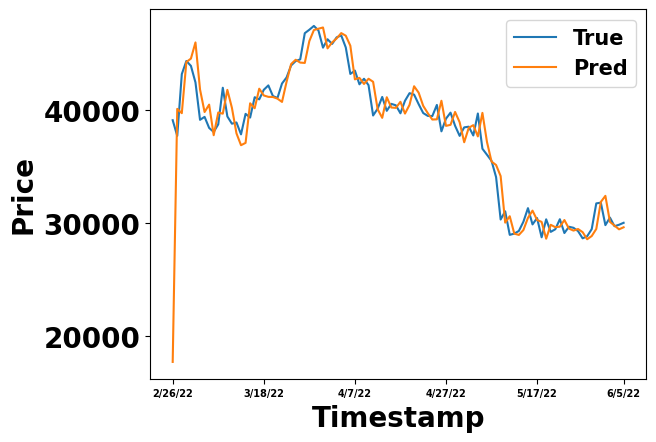

In [ ]:

train_original = scaler1.inverse_transform(daily_single_train['Close'].to_numpy().reshape(-1,1))[-100:]
prediction = scaler1.inverse_transform(np.array(model_predictions).reshape(-1,1)) [-100:]
test_original = scaler1.inverse_transform(daily_single_test['Close'].to_numpy().reshape(-1,1)) [-100:]
plt.figure()
# plt.plot(daily_single_train['Timestamp'], train_original)

plt.plot(daily_single_test['Date'][-100:], test_original, label='True')
plt.plot(daily_single_test['Date'][-100:], prediction, 
         label='Pred')
ticks = []
for i in range(5):
  ticks.append(daily_single_test['Date'][-100:][daily_single_test['Date'][-100:].index.start + i*20])
ticks.append(daily_single_test['Date'][-100:][daily_single_test['Date'][-100:].index.start + 99])
print(ticks)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.xticks(ticks , fontsize=7)
plt.legend()
# plt.suptitle('ARIMA by AIC, (p, d, q)={}'.format(
#     combs_aic[mdl_arima_best_aic]))

In [ ]:
mape = metrics.mean_absolute_percentage_error(daily_single_test['Close'], model_predictions)
mae = metrics.mean_absolute_error(daily_single_test['Close'], model_predictions)
mse = metrics.mean_squared_error(daily_single_test['Close'], model_predictions)
rmse = metrics.mean_squared_error(daily_single_test['Close'], model_predictions, squared =False)

print(mae)
print(mape)
print(mse)
print(rmse)
